# Residential Building Classification
This is a bare-bone version of the residential vs. non-residential building classification. We use DenseNet in this implementation. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision import transforms

import numpy as np
import cv2
import matplotlib.pyplot as plt

import params
from densenet_efficient import DenseNetEfficient
from solver import train, test_epoch
from dataset import *

# Load parameters
params = vars(params)
rbc_class_names = params['rbc_class_names']
fmow_class_names = params['fmow_class_names']
fmow_class_names_mini = params['fmow_class_names_mini']
dtype = params['dtype']

torch.set_num_threads(params['num_threads'])

## Preprocess FMOW Dataset
Check if fMoW dataset is available. If so, process the images by cropping based on given bounding boxes. Load in traing, validation and test dataset along with ground truth labels for training and validation set. 

In [2]:
mean = 0.5 #457.38
stdv = 0.25
train_transforms = transforms.Compose([
    Normalize(mean=mean, std=stdv),
    Rescale((224,224)),
    ToTensor(),
])
train_set = FMOWDataset(params, transform=train_transforms)
x,y = train_set[0]
print(type(x), x.shape, type(y), y.shape)
print(x)

<class 'torch.FloatTensor'> torch.Size([1, 224, 224]) <class 'torch.LongTensor'> torch.Size([1])

( 0 ,.,.) = 
   366.0000   358.5000   313.5000  ...    236.0000   248.0000   250.0000
   351.8839   344.7645   302.0480  ...    236.7439   247.3945   249.1696
   274.4732   269.4408   239.2466  ...    240.8231   244.0742   244.6161
               ...                  ⋱                 ...               
   309.7411   311.7924   324.1005  ...    270.5000   273.5000   274.0000
   293.0447   295.4755   310.0604  ...    270.5000   273.5000   274.0000
   290.0000   292.5000   307.5000  ...    270.5000   273.5000   274.0000
[torch.FloatTensor of size 1x224x224]



In [3]:
mean = 0.5 #457.38
stdv = 0.25
train_transforms = transforms.Compose([
    Normalize(mean=mean, std=stdv),
    Rescale((224,224)),
    ToTensor(),
])
test_set = FMOWDataset_test(params, transform=train_transforms)
x,y = test_set[0]
print(type(x), x.shape, type(y), y.shape)

<class 'torch.FloatTensor'> torch.Size([1, 224, 224]) <class 'torch.LongTensor'> torch.Size([1])


In [4]:
# data_test = load_test(params, mean_image=None)
# X_test = data_test['X_test']
# y_test = data_test['y_test']
# X_test_tensor = torch.from_numpy(X_test)
# y_test_tensor = torch.from_numpy(y_test)
# test_data = TensorDataset(X_test_tensor, y_test_tensor)
# loader_test = DataLoader(test_data, batch_size=params['batch_size'], sampler=RandomSampler(X_test.shape[0]))
# print(X_test.shape, X_test.dtype)
# print(y_test.shape, y_test.dtype)
# print(y_test)

### Visualize a small batch of data
Plot a small batch of training images to get a sense of data

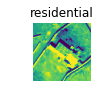

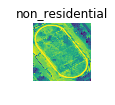

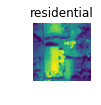

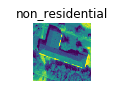

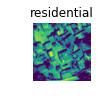

In [5]:
# Sample a minibatch and show the images and captions
size = 5
indices = np.random.choice(len(train_set), size, replace=False)

fig = plt.figure()

for i, idx in enumerate(indices):
    image, label = train_set[idx]
    plt.subplot(1, size, i + 1)
    plt.title(params['rbc_class_names'][label[0]])
    plt.axis('off')
    plt.imshow(image[0,:,:])
    plt.show()

## Load Model
Load in DenseNet. Configure training parameters. 

In [6]:
model = DenseNetEfficient(
        growth_rate=32, 
        block_config=(6, 12, 24, 16), 
        compression=0.5,
        num_init_features=64, 
        bn_size=4, 
        drop_rate=0,
        num_classes=20, 
        small_inputs=False)
# Move model to GPU
model = model.cuda()
# print(model)


/home/feng/anaconda3/envs/rbc_env/lib/python3.6/site-packages/torch/nn/modules/container.py:13: UserWarning: nn.Container is deprecated. All of it's functionality is now implemented in nn.Module. Subclass that instead.
  warnings.warn("nn.Container is deprecated. All of it's functionality "


In [7]:
# Load an existing model trained on 20 categories
model.load_state_dict(torch.load('/home/feng/ext2/feng/workspace/residential_building_challenge/output/model.dat'))

In [8]:
# Modify the model to predict 2 categories
model.classifier = nn.Sequential(
              nn.Linear(1024, 128),
              nn.ReLU(),
              nn.Linear(128, 2))

## Train Model
Train the model one epoch at a time. Keep the verbose option on to monitor the loss during training. 
Save training and validation accuracy history for visualization. 

In [9]:
train(model, 
      train_set, 
      None, 
      '/home/feng/ext2/feng/workspace/residential_building_challenge/20to2_output', 
      n_epochs=20, 
      valid_size=1000,
      batch_size=50, 
      lr=0.01, 
      wd=0.0001, 
      momentum=0.9, 
      seed=None)

Epoch: [1/20]	Iter: [1/616]	Time 1.423 (1.423)	Loss 0.6904 (0.6904)	Error 0.3800 (0.3800)
Epoch: [1/20]	Iter: [2/616]	Time 0.934 (1.178)	Loss 0.6852 (0.6878)	Error 0.4400 (0.4100)
Epoch: [1/20]	Iter: [3/616]	Time 0.888 (1.082)	Loss 0.6901 (0.6886)	Error 0.4800 (0.4333)
Epoch: [1/20]	Iter: [4/616]	Time 0.830 (1.019)	Loss 0.6855 (0.6878)	Error 0.4600 (0.4400)
Epoch: [1/20]	Iter: [5/616]	Time 0.828 (0.981)	Loss 0.6858 (0.6874)	Error 0.4600 (0.4440)
Epoch: [1/20]	Iter: [6/616]	Time 0.808 (0.952)	Loss 0.6716 (0.6848)	Error 0.4600 (0.4467)
Epoch: [1/20]	Iter: [7/616]	Time 0.856 (0.938)	Loss 0.6648 (0.6819)	Error 0.3600 (0.4343)
Epoch: [1/20]	Iter: [8/616]	Time 0.833 (0.925)	Loss 0.6719 (0.6807)	Error 0.4200 (0.4325)
Epoch: [1/20]	Iter: [9/616]	Time 0.856 (0.917)	Loss 0.6629 (0.6787)	Error 0.3400 (0.4222)
Epoch: [1/20]	Iter: [10/616]	Time 0.892 (0.915)	Loss 0.6524 (0.6761)	Error 0.2800 (0.4080)
Epoch: [1/20]	Iter: [11/616]	Time 0.881 (0.912)	Loss 0.6382 (0.6726)	Error 0.2400 (0.3927)
Epoch: [

Epoch: [1/20]	Iter: [92/616]	Time 1.201 (0.886)	Loss 0.3484 (0.4179)	Error 0.2000 (0.1791)
Epoch: [1/20]	Iter: [93/616]	Time 0.846 (0.885)	Loss 0.4176 (0.4179)	Error 0.1800 (0.1791)
Epoch: [1/20]	Iter: [94/616]	Time 0.850 (0.885)	Loss 0.3881 (0.4176)	Error 0.2000 (0.1794)
Epoch: [1/20]	Iter: [95/616]	Time 0.878 (0.885)	Loss 0.1667 (0.4150)	Error 0.0600 (0.1781)
Epoch: [1/20]	Iter: [96/616]	Time 0.826 (0.884)	Loss 0.3449 (0.4142)	Error 0.1400 (0.1777)
Epoch: [1/20]	Iter: [97/616]	Time 1.002 (0.885)	Loss 0.4832 (0.4150)	Error 0.1800 (0.1777)
Epoch: [1/20]	Iter: [98/616]	Time 0.815 (0.885)	Loss 0.2820 (0.4136)	Error 0.1000 (0.1769)
Epoch: [1/20]	Iter: [99/616]	Time 0.979 (0.886)	Loss 0.2767 (0.4122)	Error 0.1200 (0.1764)
Epoch: [1/20]	Iter: [100/616]	Time 0.893 (0.886)	Loss 0.2706 (0.4108)	Error 0.1600 (0.1762)
Epoch: [1/20]	Iter: [101/616]	Time 0.847 (0.885)	Loss 0.2587 (0.4093)	Error 0.1000 (0.1754)
Epoch: [1/20]	Iter: [102/616]	Time 0.825 (0.885)	Loss 0.4131 (0.4093)	Error 0.1800 (0.17

Epoch: [1/20]	Iter: [182/616]	Time 0.953 (0.888)	Loss 0.2980 (0.3700)	Error 0.1200 (0.1584)
Epoch: [1/20]	Iter: [183/616]	Time 0.828 (0.888)	Loss 0.2333 (0.3692)	Error 0.1000 (0.1580)
Epoch: [1/20]	Iter: [184/616]	Time 0.919 (0.888)	Loss 0.2434 (0.3685)	Error 0.1400 (0.1579)
Epoch: [1/20]	Iter: [185/616]	Time 0.853 (0.888)	Loss 0.1965 (0.3676)	Error 0.0600 (0.1574)
Epoch: [1/20]	Iter: [186/616]	Time 0.781 (0.887)	Loss 0.2667 (0.3671)	Error 0.1000 (0.1571)
Epoch: [1/20]	Iter: [187/616]	Time 0.813 (0.887)	Loss 0.3357 (0.3669)	Error 0.1400 (0.1570)
Epoch: [1/20]	Iter: [188/616]	Time 0.830 (0.887)	Loss 0.2389 (0.3662)	Error 0.1200 (0.1568)
Epoch: [1/20]	Iter: [189/616]	Time 0.860 (0.886)	Loss 0.2959 (0.3658)	Error 0.1600 (0.1568)
Epoch: [1/20]	Iter: [190/616]	Time 0.967 (0.887)	Loss 0.5763 (0.3669)	Error 0.2600 (0.1574)
Epoch: [1/20]	Iter: [191/616]	Time 0.915 (0.887)	Loss 0.2688 (0.3664)	Error 0.1000 (0.1571)
Epoch: [1/20]	Iter: [192/616]	Time 0.880 (0.887)	Loss 0.2600 (0.3659)	Error 0.10

Epoch: [1/20]	Iter: [272/616]	Time 1.064 (0.889)	Loss 0.2868 (0.3402)	Error 0.1400 (0.1446)
Epoch: [1/20]	Iter: [273/616]	Time 0.818 (0.888)	Loss 0.3247 (0.3401)	Error 0.1200 (0.1445)
Epoch: [1/20]	Iter: [274/616]	Time 0.956 (0.889)	Loss 0.1659 (0.3395)	Error 0.0600 (0.1442)
Epoch: [1/20]	Iter: [275/616]	Time 0.827 (0.889)	Loss 0.4024 (0.3397)	Error 0.1800 (0.1443)
Epoch: [1/20]	Iter: [276/616]	Time 0.934 (0.889)	Loss 0.3108 (0.3396)	Error 0.1200 (0.1442)
Epoch: [1/20]	Iter: [277/616]	Time 0.870 (0.889)	Loss 0.1862 (0.3391)	Error 0.0800 (0.1440)
Epoch: [1/20]	Iter: [278/616]	Time 0.926 (0.889)	Loss 0.1780 (0.3385)	Error 0.0800 (0.1437)
Epoch: [1/20]	Iter: [279/616]	Time 0.847 (0.889)	Loss 0.3987 (0.3387)	Error 0.1800 (0.1439)
Epoch: [1/20]	Iter: [280/616]	Time 0.806 (0.888)	Loss 0.2287 (0.3383)	Error 0.1200 (0.1438)
Epoch: [1/20]	Iter: [281/616]	Time 0.845 (0.888)	Loss 0.3523 (0.3384)	Error 0.1200 (0.1437)
Epoch: [1/20]	Iter: [282/616]	Time 0.812 (0.888)	Loss 0.2664 (0.3381)	Error 0.10

Epoch: [1/20]	Iter: [362/616]	Time 0.896 (0.887)	Loss 0.2817 (0.3273)	Error 0.1200 (0.1383)
Epoch: [1/20]	Iter: [363/616]	Time 0.799 (0.887)	Loss 0.2364 (0.3270)	Error 0.1200 (0.1383)
Epoch: [1/20]	Iter: [364/616]	Time 0.926 (0.887)	Loss 0.4252 (0.3273)	Error 0.2000 (0.1385)
Epoch: [1/20]	Iter: [365/616]	Time 0.854 (0.887)	Loss 0.2929 (0.3272)	Error 0.0800 (0.1383)
Epoch: [1/20]	Iter: [366/616]	Time 0.848 (0.886)	Loss 0.3140 (0.3272)	Error 0.1400 (0.1383)
Epoch: [1/20]	Iter: [367/616]	Time 0.827 (0.886)	Loss 0.2269 (0.3269)	Error 0.1000 (0.1382)
Epoch: [1/20]	Iter: [368/616]	Time 0.836 (0.886)	Loss 0.2699 (0.3267)	Error 0.0600 (0.1380)
Epoch: [1/20]	Iter: [369/616]	Time 0.809 (0.886)	Loss 0.2426 (0.3265)	Error 0.1200 (0.1379)
Epoch: [1/20]	Iter: [370/616]	Time 0.833 (0.886)	Loss 0.2600 (0.3263)	Error 0.1400 (0.1379)
Epoch: [1/20]	Iter: [371/616]	Time 0.847 (0.886)	Loss 0.2436 (0.3261)	Error 0.0600 (0.1377)
Epoch: [1/20]	Iter: [372/616]	Time 0.900 (0.886)	Loss 0.2670 (0.3260)	Error 0.10

Epoch: [1/20]	Iter: [452/616]	Time 0.891 (0.889)	Loss 0.3598 (0.3171)	Error 0.1200 (0.1328)
Epoch: [1/20]	Iter: [453/616]	Time 0.870 (0.889)	Loss 0.2265 (0.3169)	Error 0.0800 (0.1327)
Epoch: [1/20]	Iter: [454/616]	Time 0.862 (0.889)	Loss 0.1994 (0.3166)	Error 0.0600 (0.1325)
Epoch: [1/20]	Iter: [455/616]	Time 0.861 (0.889)	Loss 0.3567 (0.3167)	Error 0.1600 (0.1326)
Epoch: [1/20]	Iter: [456/616]	Time 0.815 (0.889)	Loss 0.2096 (0.3165)	Error 0.0800 (0.1325)
Epoch: [1/20]	Iter: [457/616]	Time 0.853 (0.889)	Loss 0.2828 (0.3164)	Error 0.1200 (0.1324)
Epoch: [1/20]	Iter: [458/616]	Time 0.841 (0.889)	Loss 0.2230 (0.3162)	Error 0.0800 (0.1323)
Epoch: [1/20]	Iter: [459/616]	Time 0.974 (0.889)	Loss 0.2291 (0.3160)	Error 0.1000 (0.1322)
Epoch: [1/20]	Iter: [460/616]	Time 0.881 (0.889)	Loss 0.2406 (0.3158)	Error 0.1400 (0.1323)
Epoch: [1/20]	Iter: [461/616]	Time 0.831 (0.889)	Loss 0.3499 (0.3159)	Error 0.1600 (0.1323)
Epoch: [1/20]	Iter: [462/616]	Time 0.844 (0.888)	Loss 0.3390 (0.3160)	Error 0.14

Epoch: [1/20]	Iter: [542/616]	Time 0.851 (0.896)	Loss 0.2011 (0.3102)	Error 0.0800 (0.1299)
Epoch: [1/20]	Iter: [543/616]	Time 0.915 (0.896)	Loss 0.2102 (0.3100)	Error 0.1200 (0.1299)
Epoch: [1/20]	Iter: [544/616]	Time 0.949 (0.896)	Loss 0.1471 (0.3097)	Error 0.0400 (0.1297)
Epoch: [1/20]	Iter: [545/616]	Time 0.826 (0.896)	Loss 0.3854 (0.3098)	Error 0.1400 (0.1297)
Epoch: [1/20]	Iter: [546/616]	Time 0.942 (0.896)	Loss 0.2574 (0.3097)	Error 0.1000 (0.1297)
Epoch: [1/20]	Iter: [547/616]	Time 0.979 (0.896)	Loss 0.4247 (0.3099)	Error 0.1800 (0.1298)
Epoch: [1/20]	Iter: [548/616]	Time 0.968 (0.896)	Loss 0.2685 (0.3099)	Error 0.1200 (0.1297)
Epoch: [1/20]	Iter: [549/616]	Time 0.892 (0.896)	Loss 0.3413 (0.3099)	Error 0.1600 (0.1298)
Epoch: [1/20]	Iter: [550/616]	Time 0.987 (0.896)	Loss 0.2859 (0.3099)	Error 0.1200 (0.1298)
Epoch: [1/20]	Iter: [551/616]	Time 0.927 (0.896)	Loss 0.1998 (0.3097)	Error 0.1000 (0.1297)
Epoch: [1/20]	Iter: [552/616]	Time 0.920 (0.896)	Loss 0.3143 (0.3097)	Error 0.12

Epoch: [2/20]	Iter: [1/616]	Time 0.800 (0.800)	Loss 0.2215 (0.2215)	Error 0.1200 (0.1200)
Epoch: [2/20]	Iter: [2/616]	Time 0.854 (0.827)	Loss 0.2557 (0.2386)	Error 0.0800 (0.1000)
Epoch: [2/20]	Iter: [3/616]	Time 0.825 (0.826)	Loss 0.1592 (0.2121)	Error 0.0600 (0.0867)
Epoch: [2/20]	Iter: [4/616]	Time 0.787 (0.817)	Loss 0.0994 (0.1840)	Error 0.0000 (0.0650)
Epoch: [2/20]	Iter: [5/616]	Time 0.827 (0.819)	Loss 0.1663 (0.1804)	Error 0.0600 (0.0640)
Epoch: [2/20]	Iter: [6/616]	Time 0.834 (0.821)	Loss 0.1748 (0.1795)	Error 0.0800 (0.0667)
Epoch: [2/20]	Iter: [7/616]	Time 0.825 (0.822)	Loss 0.2783 (0.1936)	Error 0.1400 (0.0771)
Epoch: [2/20]	Iter: [8/616]	Time 0.850 (0.825)	Loss 0.1259 (0.1851)	Error 0.0400 (0.0725)
Epoch: [2/20]	Iter: [9/616]	Time 0.798 (0.822)	Loss 0.4133 (0.2105)	Error 0.2200 (0.0889)
Epoch: [2/20]	Iter: [10/616]	Time 0.848 (0.825)	Loss 0.0993 (0.1994)	Error 0.0200 (0.0820)
Epoch: [2/20]	Iter: [11/616]	Time 0.797 (0.822)	Loss 0.2150 (0.2008)	Error 0.0800 (0.0818)
Epoch: [

Epoch: [2/20]	Iter: [92/616]	Time 0.817 (0.822)	Loss 0.1007 (0.1672)	Error 0.0400 (0.0676)
Epoch: [2/20]	Iter: [93/616]	Time 0.836 (0.823)	Loss 0.0461 (0.1659)	Error 0.0200 (0.0671)
Epoch: [2/20]	Iter: [94/616]	Time 0.820 (0.823)	Loss 0.2923 (0.1672)	Error 0.1200 (0.0677)
Epoch: [2/20]	Iter: [95/616]	Time 0.825 (0.823)	Loss 0.1278 (0.1668)	Error 0.0600 (0.0676)
Epoch: [2/20]	Iter: [96/616]	Time 0.789 (0.822)	Loss 0.2545 (0.1677)	Error 0.1400 (0.0683)
Epoch: [2/20]	Iter: [97/616]	Time 0.819 (0.822)	Loss 0.2108 (0.1682)	Error 0.0800 (0.0685)
Epoch: [2/20]	Iter: [98/616]	Time 0.851 (0.823)	Loss 0.2835 (0.1694)	Error 0.1200 (0.0690)
Epoch: [2/20]	Iter: [99/616]	Time 0.822 (0.823)	Loss 0.1303 (0.1690)	Error 0.0200 (0.0685)
Epoch: [2/20]	Iter: [100/616]	Time 0.858 (0.823)	Loss 0.1793 (0.1691)	Error 0.0400 (0.0682)
Epoch: [2/20]	Iter: [101/616]	Time 0.848 (0.823)	Loss 0.4078 (0.1714)	Error 0.1400 (0.0689)
Epoch: [2/20]	Iter: [102/616]	Time 0.833 (0.823)	Loss 0.2319 (0.1720)	Error 0.1400 (0.06

Epoch: [2/20]	Iter: [182/616]	Time 0.824 (0.823)	Loss 0.2180 (0.1778)	Error 0.1000 (0.0708)
Epoch: [2/20]	Iter: [183/616]	Time 0.810 (0.823)	Loss 0.1967 (0.1779)	Error 0.0800 (0.0708)
Epoch: [2/20]	Iter: [184/616]	Time 0.804 (0.823)	Loss 0.2023 (0.1781)	Error 0.0400 (0.0707)
Epoch: [2/20]	Iter: [185/616]	Time 0.773 (0.822)	Loss 0.1400 (0.1779)	Error 0.1000 (0.0708)
Epoch: [2/20]	Iter: [186/616]	Time 0.878 (0.823)	Loss 0.1548 (0.1777)	Error 0.0400 (0.0706)
Epoch: [2/20]	Iter: [187/616]	Time 0.806 (0.823)	Loss 0.1413 (0.1776)	Error 0.0600 (0.0706)
Epoch: [2/20]	Iter: [188/616]	Time 0.837 (0.823)	Loss 0.1863 (0.1776)	Error 0.0800 (0.0706)
Epoch: [2/20]	Iter: [189/616]	Time 0.803 (0.823)	Loss 0.2494 (0.1780)	Error 0.1200 (0.0709)
Epoch: [2/20]	Iter: [190/616]	Time 0.798 (0.823)	Loss 0.0413 (0.1773)	Error 0.0000 (0.0705)
Epoch: [2/20]	Iter: [191/616]	Time 0.803 (0.822)	Loss 0.1945 (0.1774)	Error 0.0600 (0.0705)
Epoch: [2/20]	Iter: [192/616]	Time 0.809 (0.822)	Loss 0.1445 (0.1772)	Error 0.04

Epoch: [2/20]	Iter: [272/616]	Time 0.850 (0.821)	Loss 0.1927 (0.1780)	Error 0.0600 (0.0695)
Epoch: [2/20]	Iter: [273/616]	Time 0.803 (0.821)	Loss 0.1882 (0.1780)	Error 0.0400 (0.0694)
Epoch: [2/20]	Iter: [274/616]	Time 0.810 (0.821)	Loss 0.3009 (0.1785)	Error 0.1200 (0.0696)
Epoch: [2/20]	Iter: [275/616]	Time 0.853 (0.821)	Loss 0.2014 (0.1785)	Error 0.1000 (0.0697)
Epoch: [2/20]	Iter: [276/616]	Time 0.810 (0.821)	Loss 0.1106 (0.1783)	Error 0.0400 (0.0696)
Epoch: [2/20]	Iter: [277/616]	Time 0.798 (0.821)	Loss 0.2368 (0.1785)	Error 0.0800 (0.0696)
Epoch: [2/20]	Iter: [278/616]	Time 0.815 (0.821)	Loss 0.3123 (0.1790)	Error 0.1800 (0.0700)
Epoch: [2/20]	Iter: [279/616]	Time 0.783 (0.821)	Loss 0.2334 (0.1792)	Error 0.0800 (0.0700)
Epoch: [2/20]	Iter: [280/616]	Time 0.800 (0.821)	Loss 0.0799 (0.1788)	Error 0.0400 (0.0699)
Epoch: [2/20]	Iter: [281/616]	Time 0.825 (0.821)	Loss 0.1294 (0.1787)	Error 0.0400 (0.0698)
Epoch: [2/20]	Iter: [282/616]	Time 0.778 (0.821)	Loss 0.2477 (0.1789)	Error 0.08

Epoch: [2/20]	Iter: [362/616]	Time 0.862 (0.821)	Loss 0.2560 (0.1796)	Error 0.1000 (0.0715)
Epoch: [2/20]	Iter: [363/616]	Time 0.794 (0.821)	Loss 0.0867 (0.1794)	Error 0.0200 (0.0713)
Epoch: [2/20]	Iter: [364/616]	Time 0.852 (0.821)	Loss 0.1865 (0.1794)	Error 0.0800 (0.0714)
Epoch: [2/20]	Iter: [365/616]	Time 0.779 (0.821)	Loss 0.1245 (0.1792)	Error 0.0600 (0.0713)
Epoch: [2/20]	Iter: [366/616]	Time 0.792 (0.821)	Loss 0.2975 (0.1796)	Error 0.1200 (0.0715)
Epoch: [2/20]	Iter: [367/616]	Time 0.779 (0.821)	Loss 0.2309 (0.1797)	Error 0.1200 (0.0716)
Epoch: [2/20]	Iter: [368/616]	Time 0.838 (0.821)	Loss 0.2806 (0.1800)	Error 0.1200 (0.0717)
Epoch: [2/20]	Iter: [369/616]	Time 0.826 (0.821)	Loss 0.1848 (0.1800)	Error 0.1000 (0.0718)
Epoch: [2/20]	Iter: [370/616]	Time 0.831 (0.821)	Loss 0.1073 (0.1798)	Error 0.0600 (0.0718)
Epoch: [2/20]	Iter: [371/616]	Time 0.858 (0.821)	Loss 0.1626 (0.1797)	Error 0.0600 (0.0718)
Epoch: [2/20]	Iter: [372/616]	Time 0.817 (0.821)	Loss 0.2784 (0.1800)	Error 0.10

Epoch: [2/20]	Iter: [452/616]	Time 0.845 (0.822)	Loss 0.2216 (0.1805)	Error 0.0800 (0.0726)
Epoch: [2/20]	Iter: [453/616]	Time 0.802 (0.822)	Loss 0.2051 (0.1805)	Error 0.1200 (0.0727)
Epoch: [2/20]	Iter: [454/616]	Time 0.899 (0.822)	Loss 0.2758 (0.1808)	Error 0.1200 (0.0728)
Epoch: [2/20]	Iter: [455/616]	Time 0.793 (0.822)	Loss 0.1581 (0.1807)	Error 0.0800 (0.0728)
Epoch: [2/20]	Iter: [456/616]	Time 0.808 (0.822)	Loss 0.2103 (0.1808)	Error 0.1000 (0.0729)
Epoch: [2/20]	Iter: [457/616]	Time 0.805 (0.822)	Loss 0.3872 (0.1812)	Error 0.1400 (0.0730)
Epoch: [2/20]	Iter: [458/616]	Time 0.803 (0.822)	Loss 0.2752 (0.1814)	Error 0.1200 (0.0731)
Epoch: [2/20]	Iter: [459/616]	Time 0.907 (0.822)	Loss 0.2669 (0.1816)	Error 0.1000 (0.0732)
Epoch: [2/20]	Iter: [460/616]	Time 0.825 (0.822)	Loss 0.2499 (0.1818)	Error 0.0800 (0.0732)
Epoch: [2/20]	Iter: [461/616]	Time 0.840 (0.822)	Loss 0.2135 (0.1818)	Error 0.0800 (0.0732)
Epoch: [2/20]	Iter: [462/616]	Time 0.815 (0.822)	Loss 0.1153 (0.1817)	Error 0.08

Epoch: [2/20]	Iter: [542/616]	Time 0.890 (0.822)	Loss 0.3066 (0.1842)	Error 0.1000 (0.0746)
Epoch: [2/20]	Iter: [543/616]	Time 0.782 (0.822)	Loss 0.2250 (0.1843)	Error 0.1000 (0.0747)
Epoch: [2/20]	Iter: [544/616]	Time 0.810 (0.822)	Loss 0.1942 (0.1843)	Error 0.1000 (0.0747)
Epoch: [2/20]	Iter: [545/616]	Time 0.836 (0.822)	Loss 0.1739 (0.1843)	Error 0.0600 (0.0747)
Epoch: [2/20]	Iter: [546/616]	Time 0.808 (0.822)	Loss 0.1507 (0.1842)	Error 0.0400 (0.0747)
Epoch: [2/20]	Iter: [547/616]	Time 0.811 (0.822)	Loss 0.3495 (0.1845)	Error 0.2000 (0.0749)
Epoch: [2/20]	Iter: [548/616]	Time 0.818 (0.822)	Loss 0.1988 (0.1845)	Error 0.0800 (0.0749)
Epoch: [2/20]	Iter: [549/616]	Time 0.831 (0.822)	Loss 0.1028 (0.1844)	Error 0.0600 (0.0749)
Epoch: [2/20]	Iter: [550/616]	Time 0.809 (0.822)	Loss 0.1655 (0.1844)	Error 0.0400 (0.0748)
Epoch: [2/20]	Iter: [551/616]	Time 0.793 (0.822)	Loss 0.1157 (0.1842)	Error 0.0600 (0.0748)
Epoch: [2/20]	Iter: [552/616]	Time 0.799 (0.822)	Loss 0.1383 (0.1842)	Error 0.06

Epoch: [3/20]	Iter: [1/616]	Time 0.864 (0.864)	Loss 0.1362 (0.1362)	Error 0.0400 (0.0400)
Epoch: [3/20]	Iter: [2/616]	Time 0.779 (0.821)	Loss 0.1136 (0.1249)	Error 0.0400 (0.0400)
Epoch: [3/20]	Iter: [3/616]	Time 0.773 (0.805)	Loss 0.1063 (0.1187)	Error 0.0400 (0.0400)
Epoch: [3/20]	Iter: [4/616]	Time 0.798 (0.803)	Loss 0.1372 (0.1233)	Error 0.0600 (0.0450)
Epoch: [3/20]	Iter: [5/616]	Time 0.868 (0.816)	Loss 0.0783 (0.1143)	Error 0.0200 (0.0400)
Epoch: [3/20]	Iter: [6/616]	Time 0.834 (0.819)	Loss 0.0738 (0.1076)	Error 0.0200 (0.0367)
Epoch: [3/20]	Iter: [7/616]	Time 0.823 (0.820)	Loss 0.1335 (0.1113)	Error 0.0400 (0.0371)
Epoch: [3/20]	Iter: [8/616]	Time 0.861 (0.825)	Loss 0.1203 (0.1124)	Error 0.0400 (0.0375)
Epoch: [3/20]	Iter: [9/616]	Time 0.788 (0.821)	Loss 0.2352 (0.1261)	Error 0.1000 (0.0444)
Epoch: [3/20]	Iter: [10/616]	Time 0.823 (0.821)	Loss 0.1851 (0.1320)	Error 0.1000 (0.0500)
Epoch: [3/20]	Iter: [11/616]	Time 0.815 (0.820)	Loss 0.0696 (0.1263)	Error 0.0200 (0.0473)
Epoch: [

Epoch: [3/20]	Iter: [92/616]	Time 0.802 (0.822)	Loss 0.1606 (0.1022)	Error 0.0600 (0.0370)
Epoch: [3/20]	Iter: [93/616]	Time 0.842 (0.822)	Loss 0.0272 (0.1014)	Error 0.0200 (0.0368)
Epoch: [3/20]	Iter: [94/616]	Time 0.808 (0.822)	Loss 0.0834 (0.1012)	Error 0.0400 (0.0368)
Epoch: [3/20]	Iter: [95/616]	Time 0.827 (0.822)	Loss 0.0447 (0.1006)	Error 0.0200 (0.0366)
Epoch: [3/20]	Iter: [96/616]	Time 0.793 (0.822)	Loss 0.0313 (0.0999)	Error 0.0000 (0.0362)
Epoch: [3/20]	Iter: [97/616]	Time 0.814 (0.822)	Loss 0.0751 (0.0996)	Error 0.0600 (0.0365)
Epoch: [3/20]	Iter: [98/616]	Time 0.803 (0.821)	Loss 0.1463 (0.1001)	Error 0.0200 (0.0363)
Epoch: [3/20]	Iter: [99/616]	Time 0.823 (0.821)	Loss 0.0304 (0.0994)	Error 0.0000 (0.0360)
Epoch: [3/20]	Iter: [100/616]	Time 0.771 (0.821)	Loss 0.0490 (0.0989)	Error 0.0200 (0.0358)
Epoch: [3/20]	Iter: [101/616]	Time 0.827 (0.821)	Loss 0.3372 (0.1012)	Error 0.1200 (0.0366)
Epoch: [3/20]	Iter: [102/616]	Time 0.835 (0.821)	Loss 0.1069 (0.1013)	Error 0.0400 (0.03

Epoch: [3/20]	Iter: [182/616]	Time 0.803 (0.825)	Loss 0.1918 (0.0943)	Error 0.0600 (0.0342)
Epoch: [3/20]	Iter: [183/616]	Time 0.817 (0.825)	Loss 0.0615 (0.0941)	Error 0.0000 (0.0340)
Epoch: [3/20]	Iter: [184/616]	Time 0.878 (0.826)	Loss 0.0333 (0.0938)	Error 0.0000 (0.0338)
Epoch: [3/20]	Iter: [185/616]	Time 0.790 (0.826)	Loss 0.0081 (0.0933)	Error 0.0000 (0.0336)
Epoch: [3/20]	Iter: [186/616]	Time 0.791 (0.825)	Loss 0.1231 (0.0935)	Error 0.0400 (0.0337)
Epoch: [3/20]	Iter: [187/616]	Time 0.796 (0.825)	Loss 0.0645 (0.0934)	Error 0.0200 (0.0336)
Epoch: [3/20]	Iter: [188/616]	Time 0.815 (0.825)	Loss 0.0298 (0.0930)	Error 0.0000 (0.0334)
Epoch: [3/20]	Iter: [189/616]	Time 0.798 (0.825)	Loss 0.1219 (0.0932)	Error 0.0400 (0.0334)
Epoch: [3/20]	Iter: [190/616]	Time 0.853 (0.825)	Loss 0.2370 (0.0939)	Error 0.0400 (0.0335)
Epoch: [3/20]	Iter: [191/616]	Time 0.823 (0.825)	Loss 0.1351 (0.0941)	Error 0.0800 (0.0337)
Epoch: [3/20]	Iter: [192/616]	Time 0.834 (0.825)	Loss 0.1505 (0.0944)	Error 0.06

Epoch: [3/20]	Iter: [272/616]	Time 0.807 (0.824)	Loss 0.1124 (0.0942)	Error 0.0200 (0.0345)
Epoch: [3/20]	Iter: [273/616]	Time 0.794 (0.824)	Loss 0.0305 (0.0939)	Error 0.0000 (0.0344)
Epoch: [3/20]	Iter: [274/616]	Time 0.829 (0.824)	Loss 0.2405 (0.0945)	Error 0.1200 (0.0347)
Epoch: [3/20]	Iter: [275/616]	Time 0.792 (0.824)	Loss 0.3354 (0.0953)	Error 0.1600 (0.0351)
Epoch: [3/20]	Iter: [276/616]	Time 0.833 (0.824)	Loss 0.0696 (0.0953)	Error 0.0400 (0.0351)
Epoch: [3/20]	Iter: [277/616]	Time 0.829 (0.824)	Loss 0.0630 (0.0951)	Error 0.0400 (0.0352)
Epoch: [3/20]	Iter: [278/616]	Time 0.828 (0.824)	Loss 0.1146 (0.0952)	Error 0.0800 (0.0353)
Epoch: [3/20]	Iter: [279/616]	Time 0.816 (0.824)	Loss 0.0481 (0.0950)	Error 0.0400 (0.0353)
Epoch: [3/20]	Iter: [280/616]	Time 0.794 (0.824)	Loss 0.0780 (0.0950)	Error 0.0600 (0.0354)
Epoch: [3/20]	Iter: [281/616]	Time 0.822 (0.824)	Loss 0.1867 (0.0953)	Error 0.0600 (0.0355)
Epoch: [3/20]	Iter: [282/616]	Time 0.780 (0.823)	Loss 0.1015 (0.0953)	Error 0.06

Epoch: [3/20]	Iter: [362/616]	Time 0.817 (0.824)	Loss 0.1752 (0.0971)	Error 0.0400 (0.0360)
Epoch: [3/20]	Iter: [363/616]	Time 0.834 (0.824)	Loss 0.0766 (0.0971)	Error 0.0400 (0.0360)
Epoch: [3/20]	Iter: [364/616]	Time 0.843 (0.824)	Loss 0.2468 (0.0975)	Error 0.0600 (0.0360)
Epoch: [3/20]	Iter: [365/616]	Time 0.806 (0.824)	Loss 0.0394 (0.0973)	Error 0.0200 (0.0360)
Epoch: [3/20]	Iter: [366/616]	Time 0.848 (0.824)	Loss 0.0701 (0.0972)	Error 0.0200 (0.0360)
Epoch: [3/20]	Iter: [367/616]	Time 0.820 (0.824)	Loss 0.1367 (0.0973)	Error 0.0800 (0.0361)
Epoch: [3/20]	Iter: [368/616]	Time 0.907 (0.824)	Loss 0.1203 (0.0974)	Error 0.0600 (0.0361)
Epoch: [3/20]	Iter: [369/616]	Time 0.800 (0.824)	Loss 0.1132 (0.0974)	Error 0.0600 (0.0362)
Epoch: [3/20]	Iter: [370/616]	Time 0.809 (0.824)	Loss 0.0959 (0.0974)	Error 0.0200 (0.0362)
Epoch: [3/20]	Iter: [371/616]	Time 0.802 (0.824)	Loss 0.0668 (0.0974)	Error 0.0200 (0.0361)
Epoch: [3/20]	Iter: [372/616]	Time 0.832 (0.824)	Loss 0.0499 (0.0972)	Error 0.00

Epoch: [3/20]	Iter: [452/616]	Time 0.794 (0.823)	Loss 0.1241 (0.1007)	Error 0.0400 (0.0371)
Epoch: [3/20]	Iter: [453/616]	Time 0.809 (0.823)	Loss 0.1598 (0.1008)	Error 0.0400 (0.0371)
Epoch: [3/20]	Iter: [454/616]	Time 0.804 (0.823)	Loss 0.0646 (0.1007)	Error 0.0200 (0.0371)
Epoch: [3/20]	Iter: [455/616]	Time 0.862 (0.823)	Loss 0.2206 (0.1010)	Error 0.1200 (0.0373)
Epoch: [3/20]	Iter: [456/616]	Time 0.846 (0.823)	Loss 0.0667 (0.1009)	Error 0.0200 (0.0372)
Epoch: [3/20]	Iter: [457/616]	Time 0.788 (0.823)	Loss 0.1448 (0.1010)	Error 0.0600 (0.0373)
Epoch: [3/20]	Iter: [458/616]	Time 0.838 (0.823)	Loss 0.1370 (0.1011)	Error 0.0400 (0.0373)
Epoch: [3/20]	Iter: [459/616]	Time 0.826 (0.823)	Loss 0.1020 (0.1011)	Error 0.0400 (0.0373)
Epoch: [3/20]	Iter: [460/616]	Time 0.805 (0.823)	Loss 0.2628 (0.1014)	Error 0.0600 (0.0373)
Epoch: [3/20]	Iter: [461/616]	Time 0.930 (0.823)	Loss 0.0507 (0.1013)	Error 0.0000 (0.0373)
Epoch: [3/20]	Iter: [462/616]	Time 0.788 (0.823)	Loss 0.0958 (0.1013)	Error 0.04

Epoch: [3/20]	Iter: [542/616]	Time 0.823 (0.823)	Loss 0.1119 (0.1036)	Error 0.0800 (0.0383)
Epoch: [3/20]	Iter: [543/616]	Time 0.802 (0.823)	Loss 0.1344 (0.1037)	Error 0.0600 (0.0383)
Epoch: [3/20]	Iter: [544/616]	Time 0.824 (0.823)	Loss 0.0582 (0.1036)	Error 0.0200 (0.0383)
Epoch: [3/20]	Iter: [545/616]	Time 0.832 (0.823)	Loss 0.0779 (0.1036)	Error 0.0400 (0.0383)
Epoch: [3/20]	Iter: [546/616]	Time 0.859 (0.823)	Loss 0.1145 (0.1036)	Error 0.0600 (0.0384)
Epoch: [3/20]	Iter: [547/616]	Time 0.803 (0.823)	Loss 0.1100 (0.1036)	Error 0.0800 (0.0384)
Epoch: [3/20]	Iter: [548/616]	Time 0.831 (0.823)	Loss 0.1499 (0.1037)	Error 0.0600 (0.0385)
Epoch: [3/20]	Iter: [549/616]	Time 0.828 (0.823)	Loss 0.2295 (0.1039)	Error 0.1000 (0.0386)
Epoch: [3/20]	Iter: [550/616]	Time 0.804 (0.823)	Loss 0.0759 (0.1039)	Error 0.0200 (0.0385)
Epoch: [3/20]	Iter: [551/616]	Time 0.845 (0.823)	Loss 0.1738 (0.1040)	Error 0.0400 (0.0385)
Epoch: [3/20]	Iter: [552/616]	Time 0.795 (0.823)	Loss 0.1036 (0.1040)	Error 0.04

Epoch: [4/20]	Iter: [1/616]	Time 0.776 (0.776)	Loss 0.0552 (0.0552)	Error 0.0200 (0.0200)
Epoch: [4/20]	Iter: [2/616]	Time 0.781 (0.778)	Loss 0.0166 (0.0359)	Error 0.0000 (0.0100)
Epoch: [4/20]	Iter: [3/616]	Time 0.742 (0.766)	Loss 0.0202 (0.0307)	Error 0.0000 (0.0067)
Epoch: [4/20]	Iter: [4/616]	Time 0.764 (0.766)	Loss 0.0264 (0.0296)	Error 0.0000 (0.0050)
Epoch: [4/20]	Iter: [5/616]	Time 0.759 (0.764)	Loss 0.1338 (0.0504)	Error 0.0400 (0.0120)
Epoch: [4/20]	Iter: [6/616]	Time 0.750 (0.762)	Loss 0.0697 (0.0536)	Error 0.0200 (0.0133)
Epoch: [4/20]	Iter: [7/616]	Time 0.802 (0.768)	Loss 0.0450 (0.0524)	Error 0.0200 (0.0143)
Epoch: [4/20]	Iter: [8/616]	Time 0.767 (0.768)	Loss 0.1590 (0.0657)	Error 0.0400 (0.0175)
Epoch: [4/20]	Iter: [9/616]	Time 0.785 (0.769)	Loss 0.0795 (0.0673)	Error 0.0400 (0.0200)
Epoch: [4/20]	Iter: [10/616]	Time 0.752 (0.768)	Loss 0.1522 (0.0757)	Error 0.0400 (0.0220)
Epoch: [4/20]	Iter: [11/616]	Time 0.777 (0.769)	Loss 0.0834 (0.0764)	Error 0.0400 (0.0236)
Epoch: [

Epoch: [4/20]	Iter: [92/616]	Time 0.822 (0.816)	Loss 0.1327 (0.0603)	Error 0.0600 (0.0211)
Epoch: [4/20]	Iter: [93/616]	Time 0.792 (0.816)	Loss 0.0998 (0.0607)	Error 0.0200 (0.0211)
Epoch: [4/20]	Iter: [94/616]	Time 0.832 (0.816)	Loss 0.0279 (0.0604)	Error 0.0000 (0.0209)
Epoch: [4/20]	Iter: [95/616]	Time 0.834 (0.817)	Loss 0.0699 (0.0605)	Error 0.0200 (0.0208)
Epoch: [4/20]	Iter: [96/616]	Time 0.809 (0.816)	Loss 0.0137 (0.0600)	Error 0.0000 (0.0206)
Epoch: [4/20]	Iter: [97/616]	Time 0.799 (0.816)	Loss 0.0872 (0.0603)	Error 0.0200 (0.0206)
Epoch: [4/20]	Iter: [98/616]	Time 0.828 (0.816)	Loss 0.0158 (0.0598)	Error 0.0000 (0.0204)
Epoch: [4/20]	Iter: [99/616]	Time 0.824 (0.816)	Loss 0.0354 (0.0596)	Error 0.0000 (0.0202)
Epoch: [4/20]	Iter: [100/616]	Time 0.836 (0.817)	Loss 0.0327 (0.0593)	Error 0.0200 (0.0202)
Epoch: [4/20]	Iter: [101/616]	Time 0.817 (0.817)	Loss 0.0479 (0.0592)	Error 0.0200 (0.0202)
Epoch: [4/20]	Iter: [102/616]	Time 0.831 (0.817)	Loss 0.1863 (0.0605)	Error 0.0400 (0.02

Epoch: [4/20]	Iter: [182/616]	Time 0.868 (0.819)	Loss 0.0989 (0.0647)	Error 0.0400 (0.0237)
Epoch: [4/20]	Iter: [183/616]	Time 0.779 (0.819)	Loss 0.1355 (0.0651)	Error 0.0200 (0.0237)
Epoch: [4/20]	Iter: [184/616]	Time 0.842 (0.819)	Loss 0.0353 (0.0649)	Error 0.0200 (0.0237)
Epoch: [4/20]	Iter: [185/616]	Time 0.862 (0.819)	Loss 0.0527 (0.0649)	Error 0.0200 (0.0237)
Epoch: [4/20]	Iter: [186/616]	Time 0.812 (0.819)	Loss 0.0137 (0.0646)	Error 0.0000 (0.0235)
Epoch: [4/20]	Iter: [187/616]	Time 0.846 (0.819)	Loss 0.0988 (0.0648)	Error 0.0400 (0.0236)
Epoch: [4/20]	Iter: [188/616]	Time 0.820 (0.819)	Loss 0.0607 (0.0648)	Error 0.0400 (0.0237)
Epoch: [4/20]	Iter: [189/616]	Time 0.824 (0.819)	Loss 0.0237 (0.0645)	Error 0.0000 (0.0236)
Epoch: [4/20]	Iter: [190/616]	Time 0.802 (0.819)	Loss 0.0213 (0.0643)	Error 0.0000 (0.0235)
Epoch: [4/20]	Iter: [191/616]	Time 0.830 (0.819)	Loss 0.0518 (0.0642)	Error 0.0200 (0.0235)
Epoch: [4/20]	Iter: [192/616]	Time 0.894 (0.819)	Loss 0.1167 (0.0645)	Error 0.06

Epoch: [4/20]	Iter: [272/616]	Time 0.828 (0.820)	Loss 0.0470 (0.0675)	Error 0.0200 (0.0244)
Epoch: [4/20]	Iter: [273/616]	Time 0.798 (0.820)	Loss 0.1579 (0.0678)	Error 0.0400 (0.0245)
Epoch: [4/20]	Iter: [274/616]	Time 0.819 (0.820)	Loss 0.0232 (0.0677)	Error 0.0000 (0.0244)
Epoch: [4/20]	Iter: [275/616]	Time 0.821 (0.820)	Loss 0.0509 (0.0676)	Error 0.0200 (0.0244)
Epoch: [4/20]	Iter: [276/616]	Time 0.817 (0.820)	Loss 0.0754 (0.0676)	Error 0.0200 (0.0243)
Epoch: [4/20]	Iter: [277/616]	Time 0.769 (0.820)	Loss 0.0182 (0.0675)	Error 0.0000 (0.0243)
Epoch: [4/20]	Iter: [278/616]	Time 0.832 (0.820)	Loss 0.1715 (0.0678)	Error 0.0400 (0.0243)
Epoch: [4/20]	Iter: [279/616]	Time 0.820 (0.820)	Loss 0.0048 (0.0676)	Error 0.0000 (0.0242)
Epoch: [4/20]	Iter: [280/616]	Time 0.819 (0.820)	Loss 0.0433 (0.0675)	Error 0.0000 (0.0241)
Epoch: [4/20]	Iter: [281/616]	Time 0.810 (0.820)	Loss 0.0218 (0.0674)	Error 0.0000 (0.0241)
Epoch: [4/20]	Iter: [282/616]	Time 0.782 (0.820)	Loss 0.0310 (0.0672)	Error 0.00

Epoch: [4/20]	Iter: [362/616]	Time 0.823 (0.819)	Loss 0.2053 (0.0667)	Error 0.1200 (0.0240)
Epoch: [4/20]	Iter: [363/616]	Time 0.821 (0.819)	Loss 0.0630 (0.0667)	Error 0.0200 (0.0240)
Epoch: [4/20]	Iter: [364/616]	Time 0.901 (0.819)	Loss 0.0759 (0.0667)	Error 0.0400 (0.0241)
Epoch: [4/20]	Iter: [365/616]	Time 0.822 (0.819)	Loss 0.0051 (0.0665)	Error 0.0000 (0.0240)
Epoch: [4/20]	Iter: [366/616]	Time 0.801 (0.819)	Loss 0.0059 (0.0664)	Error 0.0000 (0.0239)
Epoch: [4/20]	Iter: [367/616]	Time 0.845 (0.819)	Loss 0.0546 (0.0663)	Error 0.0200 (0.0239)
Epoch: [4/20]	Iter: [368/616]	Time 0.838 (0.819)	Loss 0.0144 (0.0662)	Error 0.0000 (0.0239)
Epoch: [4/20]	Iter: [369/616]	Time 0.802 (0.819)	Loss 0.0898 (0.0662)	Error 0.0400 (0.0239)
Epoch: [4/20]	Iter: [370/616]	Time 0.854 (0.819)	Loss 0.0119 (0.0661)	Error 0.0000 (0.0238)
Epoch: [4/20]	Iter: [371/616]	Time 0.833 (0.820)	Loss 0.0308 (0.0660)	Error 0.0000 (0.0238)
Epoch: [4/20]	Iter: [372/616]	Time 0.766 (0.819)	Loss 0.0422 (0.0659)	Error 0.02

Epoch: [4/20]	Iter: [452/616]	Time 0.906 (0.820)	Loss 0.1322 (0.0659)	Error 0.0400 (0.0240)
Epoch: [4/20]	Iter: [453/616]	Time 0.863 (0.820)	Loss 0.2933 (0.0664)	Error 0.1000 (0.0242)
Epoch: [4/20]	Iter: [454/616]	Time 0.800 (0.820)	Loss 0.0234 (0.0663)	Error 0.0000 (0.0241)
Epoch: [4/20]	Iter: [455/616]	Time 0.801 (0.820)	Loss 0.0585 (0.0663)	Error 0.0400 (0.0241)
Epoch: [4/20]	Iter: [456/616]	Time 0.789 (0.820)	Loss 0.0562 (0.0663)	Error 0.0200 (0.0241)
Epoch: [4/20]	Iter: [457/616]	Time 0.840 (0.820)	Loss 0.0349 (0.0662)	Error 0.0000 (0.0241)
Epoch: [4/20]	Iter: [458/616]	Time 0.885 (0.820)	Loss 0.0596 (0.0662)	Error 0.0400 (0.0241)
Epoch: [4/20]	Iter: [459/616]	Time 0.859 (0.820)	Loss 0.0219 (0.0661)	Error 0.0000 (0.0241)
Epoch: [4/20]	Iter: [460/616]	Time 0.841 (0.820)	Loss 0.0742 (0.0661)	Error 0.0400 (0.0241)
Epoch: [4/20]	Iter: [461/616]	Time 0.842 (0.820)	Loss 0.1206 (0.0662)	Error 0.0400 (0.0241)
Epoch: [4/20]	Iter: [462/616]	Time 0.830 (0.820)	Loss 0.0373 (0.0662)	Error 0.02

Epoch: [4/20]	Iter: [542/616]	Time 0.831 (0.820)	Loss 0.0322 (0.0686)	Error 0.0000 (0.0252)
Epoch: [4/20]	Iter: [543/616]	Time 0.824 (0.820)	Loss 0.0484 (0.0686)	Error 0.0200 (0.0252)
Epoch: [4/20]	Iter: [544/616]	Time 0.849 (0.820)	Loss 0.0359 (0.0685)	Error 0.0200 (0.0251)
Epoch: [4/20]	Iter: [545/616]	Time 0.887 (0.821)	Loss 0.1424 (0.0686)	Error 0.1000 (0.0253)
Epoch: [4/20]	Iter: [546/616]	Time 0.825 (0.821)	Loss 0.0519 (0.0686)	Error 0.0000 (0.0252)
Epoch: [4/20]	Iter: [547/616]	Time 0.832 (0.821)	Loss 0.0909 (0.0686)	Error 0.0200 (0.0252)
Epoch: [4/20]	Iter: [548/616]	Time 0.849 (0.821)	Loss 0.0088 (0.0685)	Error 0.0000 (0.0252)
Epoch: [4/20]	Iter: [549/616]	Time 0.829 (0.821)	Loss 0.1181 (0.0686)	Error 0.0800 (0.0253)
Epoch: [4/20]	Iter: [550/616]	Time 0.809 (0.821)	Loss 0.1087 (0.0687)	Error 0.0200 (0.0253)
Epoch: [4/20]	Iter: [551/616]	Time 0.824 (0.821)	Loss 0.0148 (0.0686)	Error 0.0000 (0.0252)
Epoch: [4/20]	Iter: [552/616]	Time 0.807 (0.821)	Loss 0.1192 (0.0687)	Error 0.04

Epoch: [5/20]	Iter: [1/616]	Time 0.777 (0.777)	Loss 0.0340 (0.0340)	Error 0.0000 (0.0000)
Epoch: [5/20]	Iter: [2/616]	Time 0.766 (0.772)	Loss 0.1015 (0.0678)	Error 0.0200 (0.0100)
Epoch: [5/20]	Iter: [3/616]	Time 0.821 (0.788)	Loss 0.0145 (0.0500)	Error 0.0000 (0.0067)
Epoch: [5/20]	Iter: [4/616]	Time 0.799 (0.791)	Loss 0.0095 (0.0399)	Error 0.0000 (0.0050)
Epoch: [5/20]	Iter: [5/616]	Time 0.790 (0.791)	Loss 0.0246 (0.0368)	Error 0.0000 (0.0040)
Epoch: [5/20]	Iter: [6/616]	Time 0.804 (0.793)	Loss 0.0310 (0.0359)	Error 0.0200 (0.0067)
Epoch: [5/20]	Iter: [7/616]	Time 0.834 (0.799)	Loss 0.0454 (0.0372)	Error 0.0200 (0.0086)
Epoch: [5/20]	Iter: [8/616]	Time 0.828 (0.803)	Loss 0.0088 (0.0337)	Error 0.0000 (0.0075)
Epoch: [5/20]	Iter: [9/616]	Time 0.832 (0.806)	Loss 0.0210 (0.0323)	Error 0.0000 (0.0067)
Epoch: [5/20]	Iter: [10/616]	Time 0.824 (0.808)	Loss 0.0170 (0.0307)	Error 0.0000 (0.0060)
Epoch: [5/20]	Iter: [11/616]	Time 0.803 (0.807)	Loss 0.0049 (0.0284)	Error 0.0000 (0.0055)
Epoch: [

Epoch: [5/20]	Iter: [92/616]	Time 0.799 (0.822)	Loss 0.1123 (0.0367)	Error 0.0600 (0.0130)
Epoch: [5/20]	Iter: [93/616]	Time 0.813 (0.822)	Loss 0.0071 (0.0364)	Error 0.0000 (0.0129)
Epoch: [5/20]	Iter: [94/616]	Time 0.832 (0.822)	Loss 0.1447 (0.0376)	Error 0.0600 (0.0134)
Epoch: [5/20]	Iter: [95/616]	Time 0.795 (0.822)	Loss 0.0045 (0.0372)	Error 0.0000 (0.0133)
Epoch: [5/20]	Iter: [96/616]	Time 0.807 (0.821)	Loss 0.0829 (0.0377)	Error 0.0400 (0.0135)
Epoch: [5/20]	Iter: [97/616]	Time 0.911 (0.822)	Loss 0.0552 (0.0379)	Error 0.0200 (0.0136)
Epoch: [5/20]	Iter: [98/616]	Time 0.800 (0.822)	Loss 0.0109 (0.0376)	Error 0.0000 (0.0135)
Epoch: [5/20]	Iter: [99/616]	Time 0.837 (0.822)	Loss 0.1089 (0.0383)	Error 0.0400 (0.0137)
Epoch: [5/20]	Iter: [100/616]	Time 0.784 (0.822)	Loss 0.0573 (0.0385)	Error 0.0200 (0.0138)
Epoch: [5/20]	Iter: [101/616]	Time 0.802 (0.822)	Loss 0.1941 (0.0401)	Error 0.0800 (0.0145)
Epoch: [5/20]	Iter: [102/616]	Time 0.812 (0.822)	Loss 0.0880 (0.0405)	Error 0.0400 (0.01

Epoch: [5/20]	Iter: [182/616]	Time 0.793 (0.823)	Loss 0.0310 (0.0412)	Error 0.0200 (0.0154)
Epoch: [5/20]	Iter: [183/616]	Time 0.846 (0.823)	Loss 0.0412 (0.0412)	Error 0.0200 (0.0154)
Epoch: [5/20]	Iter: [184/616]	Time 0.840 (0.823)	Loss 0.0458 (0.0413)	Error 0.0200 (0.0154)
Epoch: [5/20]	Iter: [185/616]	Time 0.871 (0.823)	Loss 0.0144 (0.0411)	Error 0.0000 (0.0154)
Epoch: [5/20]	Iter: [186/616]	Time 0.801 (0.823)	Loss 0.0068 (0.0409)	Error 0.0000 (0.0153)
Epoch: [5/20]	Iter: [187/616]	Time 0.830 (0.823)	Loss 0.0219 (0.0408)	Error 0.0000 (0.0152)
Epoch: [5/20]	Iter: [188/616]	Time 0.829 (0.823)	Loss 0.0026 (0.0406)	Error 0.0000 (0.0151)
Epoch: [5/20]	Iter: [189/616]	Time 0.815 (0.823)	Loss 0.0043 (0.0404)	Error 0.0000 (0.0150)
Epoch: [5/20]	Iter: [190/616]	Time 0.801 (0.823)	Loss 0.0441 (0.0405)	Error 0.0200 (0.0151)
Epoch: [5/20]	Iter: [191/616]	Time 0.806 (0.823)	Loss 0.0534 (0.0405)	Error 0.0200 (0.0151)
Epoch: [5/20]	Iter: [192/616]	Time 0.824 (0.823)	Loss 0.0262 (0.0405)	Error 0.00

Epoch: [5/20]	Iter: [272/616]	Time 0.819 (0.823)	Loss 0.0034 (0.0414)	Error 0.0000 (0.0144)
Epoch: [5/20]	Iter: [273/616]	Time 0.829 (0.823)	Loss 0.0220 (0.0413)	Error 0.0000 (0.0144)
Epoch: [5/20]	Iter: [274/616]	Time 0.813 (0.823)	Loss 0.0277 (0.0413)	Error 0.0000 (0.0143)
Epoch: [5/20]	Iter: [275/616]	Time 0.823 (0.823)	Loss 0.0467 (0.0413)	Error 0.0200 (0.0143)
Epoch: [5/20]	Iter: [276/616]	Time 0.834 (0.823)	Loss 0.0068 (0.0412)	Error 0.0000 (0.0143)
Epoch: [5/20]	Iter: [277/616]	Time 0.841 (0.823)	Loss 0.0787 (0.0413)	Error 0.0200 (0.0143)
Epoch: [5/20]	Iter: [278/616]	Time 0.770 (0.823)	Loss 0.0298 (0.0413)	Error 0.0000 (0.0142)
Epoch: [5/20]	Iter: [279/616]	Time 0.813 (0.823)	Loss 0.0226 (0.0412)	Error 0.0200 (0.0143)
Epoch: [5/20]	Iter: [280/616]	Time 0.815 (0.823)	Loss 0.0085 (0.0411)	Error 0.0000 (0.0142)
Epoch: [5/20]	Iter: [281/616]	Time 0.807 (0.823)	Loss 0.1483 (0.0415)	Error 0.0200 (0.0142)
Epoch: [5/20]	Iter: [282/616]	Time 0.828 (0.823)	Loss 0.0300 (0.0414)	Error 0.02

Epoch: [5/20]	Iter: [362/616]	Time 0.813 (0.823)	Loss 0.0153 (0.0444)	Error 0.0000 (0.0157)
Epoch: [5/20]	Iter: [363/616]	Time 0.804 (0.823)	Loss 0.0168 (0.0443)	Error 0.0000 (0.0156)
Epoch: [5/20]	Iter: [364/616]	Time 0.820 (0.823)	Loss 0.0178 (0.0442)	Error 0.0200 (0.0157)
Epoch: [5/20]	Iter: [365/616]	Time 0.832 (0.823)	Loss 0.0489 (0.0442)	Error 0.0400 (0.0157)
Epoch: [5/20]	Iter: [366/616]	Time 0.783 (0.823)	Loss 0.0650 (0.0443)	Error 0.0400 (0.0158)
Epoch: [5/20]	Iter: [367/616]	Time 0.777 (0.822)	Loss 0.0931 (0.0444)	Error 0.0400 (0.0159)
Epoch: [5/20]	Iter: [368/616]	Time 0.799 (0.822)	Loss 0.0314 (0.0444)	Error 0.0000 (0.0158)
Epoch: [5/20]	Iter: [369/616]	Time 0.817 (0.822)	Loss 0.0386 (0.0444)	Error 0.0000 (0.0158)
Epoch: [5/20]	Iter: [370/616]	Time 0.802 (0.822)	Loss 0.0564 (0.0444)	Error 0.0200 (0.0158)
Epoch: [5/20]	Iter: [371/616]	Time 0.770 (0.822)	Loss 0.0399 (0.0444)	Error 0.0200 (0.0158)
Epoch: [5/20]	Iter: [372/616]	Time 0.771 (0.822)	Loss 0.2533 (0.0449)	Error 0.12

Epoch: [5/20]	Iter: [452/616]	Time 0.785 (0.823)	Loss 0.0956 (0.0480)	Error 0.0400 (0.0180)
Epoch: [5/20]	Iter: [453/616]	Time 0.829 (0.823)	Loss 0.2783 (0.0485)	Error 0.1400 (0.0182)
Epoch: [5/20]	Iter: [454/616]	Time 0.812 (0.823)	Loss 0.0051 (0.0484)	Error 0.0000 (0.0182)
Epoch: [5/20]	Iter: [455/616]	Time 0.867 (0.823)	Loss 0.0380 (0.0484)	Error 0.0200 (0.0182)
Epoch: [5/20]	Iter: [456/616]	Time 0.827 (0.823)	Loss 0.1294 (0.0486)	Error 0.0600 (0.0183)
Epoch: [5/20]	Iter: [457/616]	Time 0.792 (0.823)	Loss 0.0350 (0.0486)	Error 0.0200 (0.0183)
Epoch: [5/20]	Iter: [458/616]	Time 0.780 (0.823)	Loss 0.0262 (0.0485)	Error 0.0000 (0.0183)
Epoch: [5/20]	Iter: [459/616]	Time 0.885 (0.823)	Loss 0.1858 (0.0488)	Error 0.0600 (0.0183)
Epoch: [5/20]	Iter: [460/616]	Time 0.821 (0.823)	Loss 0.0464 (0.0488)	Error 0.0200 (0.0183)
Epoch: [5/20]	Iter: [461/616]	Time 0.840 (0.823)	Loss 0.0849 (0.0489)	Error 0.0400 (0.0184)
Epoch: [5/20]	Iter: [462/616]	Time 0.830 (0.823)	Loss 0.0202 (0.0488)	Error 0.00

Epoch: [5/20]	Iter: [542/616]	Time 0.805 (0.823)	Loss 0.0793 (0.0506)	Error 0.0200 (0.0186)
Epoch: [5/20]	Iter: [543/616]	Time 0.835 (0.823)	Loss 0.0114 (0.0505)	Error 0.0000 (0.0186)
Epoch: [5/20]	Iter: [544/616]	Time 0.787 (0.823)	Loss 0.1679 (0.0507)	Error 0.0400 (0.0186)
Epoch: [5/20]	Iter: [545/616]	Time 0.804 (0.823)	Loss 0.1641 (0.0509)	Error 0.0400 (0.0187)
Epoch: [5/20]	Iter: [546/616]	Time 0.794 (0.823)	Loss 0.0881 (0.0510)	Error 0.0400 (0.0187)
Epoch: [5/20]	Iter: [547/616]	Time 0.780 (0.823)	Loss 0.2656 (0.0514)	Error 0.1000 (0.0189)
Epoch: [5/20]	Iter: [548/616]	Time 0.794 (0.823)	Loss 0.0935 (0.0515)	Error 0.0400 (0.0189)
Epoch: [5/20]	Iter: [549/616]	Time 0.876 (0.823)	Loss 0.0164 (0.0514)	Error 0.0000 (0.0189)
Epoch: [5/20]	Iter: [550/616]	Time 0.801 (0.823)	Loss 0.0679 (0.0514)	Error 0.0400 (0.0189)
Epoch: [5/20]	Iter: [551/616]	Time 0.820 (0.823)	Loss 0.0734 (0.0515)	Error 0.0600 (0.0190)
Epoch: [5/20]	Iter: [552/616]	Time 0.859 (0.823)	Loss 0.0955 (0.0516)	Error 0.04

Epoch: [6/20]	Iter: [1/616]	Time 0.748 (0.748)	Loss 0.0285 (0.0285)	Error 0.0000 (0.0000)
Epoch: [6/20]	Iter: [2/616]	Time 0.782 (0.765)	Loss 0.0231 (0.0258)	Error 0.0000 (0.0000)
Epoch: [6/20]	Iter: [3/616]	Time 0.752 (0.761)	Loss 0.0435 (0.0317)	Error 0.0200 (0.0067)
Epoch: [6/20]	Iter: [4/616]	Time 0.840 (0.781)	Loss 0.0362 (0.0328)	Error 0.0000 (0.0050)
Epoch: [6/20]	Iter: [5/616]	Time 0.811 (0.787)	Loss 0.0048 (0.0272)	Error 0.0000 (0.0040)
Epoch: [6/20]	Iter: [6/616]	Time 0.758 (0.782)	Loss 0.0345 (0.0284)	Error 0.0000 (0.0033)
Epoch: [6/20]	Iter: [7/616]	Time 0.799 (0.784)	Loss 0.0222 (0.0275)	Error 0.0000 (0.0029)
Epoch: [6/20]	Iter: [8/616]	Time 0.757 (0.781)	Loss 0.0087 (0.0252)	Error 0.0000 (0.0025)
Epoch: [6/20]	Iter: [9/616]	Time 0.769 (0.780)	Loss 0.0335 (0.0261)	Error 0.0200 (0.0044)
Epoch: [6/20]	Iter: [10/616]	Time 0.763 (0.778)	Loss 0.0228 (0.0258)	Error 0.0000 (0.0040)
Epoch: [6/20]	Iter: [11/616]	Time 0.762 (0.776)	Loss 0.0164 (0.0249)	Error 0.0000 (0.0036)
Epoch: [

Epoch: [6/20]	Iter: [92/616]	Time 0.790 (0.818)	Loss 0.0240 (0.0370)	Error 0.0000 (0.0133)
Epoch: [6/20]	Iter: [93/616]	Time 0.778 (0.818)	Loss 0.0382 (0.0370)	Error 0.0200 (0.0133)
Epoch: [6/20]	Iter: [94/616]	Time 0.817 (0.818)	Loss 0.0118 (0.0367)	Error 0.0000 (0.0132)
Epoch: [6/20]	Iter: [95/616]	Time 0.800 (0.818)	Loss 0.0274 (0.0366)	Error 0.0000 (0.0131)
Epoch: [6/20]	Iter: [96/616]	Time 0.825 (0.818)	Loss 0.0103 (0.0363)	Error 0.0000 (0.0129)
Epoch: [6/20]	Iter: [97/616]	Time 0.880 (0.818)	Loss 0.1065 (0.0371)	Error 0.0600 (0.0134)
Epoch: [6/20]	Iter: [98/616]	Time 0.804 (0.818)	Loss 0.0295 (0.0370)	Error 0.0000 (0.0133)
Epoch: [6/20]	Iter: [99/616]	Time 0.775 (0.818)	Loss 0.0887 (0.0375)	Error 0.0400 (0.0135)
Epoch: [6/20]	Iter: [100/616]	Time 0.880 (0.818)	Loss 0.0600 (0.0377)	Error 0.0200 (0.0136)
Epoch: [6/20]	Iter: [101/616]	Time 0.917 (0.819)	Loss 0.0122 (0.0375)	Error 0.0000 (0.0135)
Epoch: [6/20]	Iter: [102/616]	Time 1.095 (0.822)	Loss 0.0102 (0.0372)	Error 0.0000 (0.01

Epoch: [6/20]	Iter: [182/616]	Time 1.214 (0.995)	Loss 0.0693 (0.0389)	Error 0.0200 (0.0147)
Epoch: [6/20]	Iter: [183/616]	Time 1.290 (0.997)	Loss 0.0058 (0.0387)	Error 0.0000 (0.0146)
Epoch: [6/20]	Iter: [184/616]	Time 1.205 (0.998)	Loss 0.0426 (0.0387)	Error 0.0200 (0.0147)
Epoch: [6/20]	Iter: [185/616]	Time 1.200 (0.999)	Loss 0.0131 (0.0386)	Error 0.0000 (0.0146)
Epoch: [6/20]	Iter: [186/616]	Time 1.206 (1.000)	Loss 0.0049 (0.0384)	Error 0.0000 (0.0145)
Epoch: [6/20]	Iter: [187/616]	Time 1.195 (1.001)	Loss 0.0021 (0.0382)	Error 0.0000 (0.0144)
Epoch: [6/20]	Iter: [188/616]	Time 1.204 (1.002)	Loss 0.0321 (0.0382)	Error 0.0200 (0.0145)
Epoch: [6/20]	Iter: [189/616]	Time 1.221 (1.004)	Loss 0.0261 (0.0381)	Error 0.0200 (0.0145)
Epoch: [6/20]	Iter: [190/616]	Time 1.170 (1.004)	Loss 0.0368 (0.0381)	Error 0.0200 (0.0145)
Epoch: [6/20]	Iter: [191/616]	Time 1.275 (1.006)	Loss 0.0063 (0.0380)	Error 0.0000 (0.0145)
Epoch: [6/20]	Iter: [192/616]	Time 1.214 (1.007)	Loss 0.0312 (0.0379)	Error 0.00

Epoch: [6/20]	Iter: [272/616]	Time 1.238 (1.071)	Loss 0.0535 (0.0392)	Error 0.0200 (0.0151)
Epoch: [6/20]	Iter: [273/616]	Time 1.190 (1.071)	Loss 0.0083 (0.0391)	Error 0.0000 (0.0150)
Epoch: [6/20]	Iter: [274/616]	Time 1.290 (1.072)	Loss 0.0185 (0.0390)	Error 0.0000 (0.0150)
Epoch: [6/20]	Iter: [275/616]	Time 1.187 (1.072)	Loss 0.0244 (0.0390)	Error 0.0200 (0.0150)
Epoch: [6/20]	Iter: [276/616]	Time 1.222 (1.073)	Loss 0.0110 (0.0389)	Error 0.0000 (0.0149)
Epoch: [6/20]	Iter: [277/616]	Time 1.274 (1.073)	Loss 0.0299 (0.0388)	Error 0.0000 (0.0149)
Epoch: [6/20]	Iter: [278/616]	Time 1.201 (1.074)	Loss 0.0041 (0.0387)	Error 0.0000 (0.0148)
Epoch: [6/20]	Iter: [279/616]	Time 1.200 (1.074)	Loss 0.0265 (0.0386)	Error 0.0200 (0.0148)
Epoch: [6/20]	Iter: [280/616]	Time 1.185 (1.075)	Loss 0.0057 (0.0385)	Error 0.0000 (0.0148)
Epoch: [6/20]	Iter: [281/616]	Time 1.221 (1.075)	Loss 0.0842 (0.0387)	Error 0.0600 (0.0149)
Epoch: [6/20]	Iter: [282/616]	Time 1.214 (1.076)	Loss 0.0204 (0.0386)	Error 0.00

Epoch: [6/20]	Iter: [362/616]	Time 1.246 (1.109)	Loss 0.0077 (0.0400)	Error 0.0000 (0.0159)
Epoch: [6/20]	Iter: [363/616]	Time 1.212 (1.110)	Loss 0.0604 (0.0400)	Error 0.0200 (0.0159)
Epoch: [6/20]	Iter: [364/616]	Time 1.173 (1.110)	Loss 0.0501 (0.0401)	Error 0.0400 (0.0159)
Epoch: [6/20]	Iter: [365/616]	Time 1.189 (1.110)	Loss 0.0166 (0.0400)	Error 0.0000 (0.0159)
Epoch: [6/20]	Iter: [366/616]	Time 1.216 (1.110)	Loss 0.0163 (0.0399)	Error 0.0000 (0.0158)
Epoch: [6/20]	Iter: [367/616]	Time 1.182 (1.110)	Loss 0.0041 (0.0398)	Error 0.0000 (0.0158)
Epoch: [6/20]	Iter: [368/616]	Time 1.206 (1.111)	Loss 0.0276 (0.0398)	Error 0.0200 (0.0158)
Epoch: [6/20]	Iter: [369/616]	Time 1.242 (1.111)	Loss 0.0708 (0.0399)	Error 0.0400 (0.0159)
Epoch: [6/20]	Iter: [370/616]	Time 1.286 (1.111)	Loss 0.0180 (0.0398)	Error 0.0000 (0.0158)
Epoch: [6/20]	Iter: [371/616]	Time 1.252 (1.112)	Loss 0.0252 (0.0398)	Error 0.0200 (0.0158)
Epoch: [6/20]	Iter: [372/616]	Time 1.264 (1.112)	Loss 0.0051 (0.0397)	Error 0.00

Epoch: [6/20]	Iter: [452/616]	Time 1.208 (1.131)	Loss 0.0530 (0.0447)	Error 0.0200 (0.0173)
Epoch: [6/20]	Iter: [453/616]	Time 1.220 (1.131)	Loss 0.1128 (0.0449)	Error 0.0400 (0.0174)
Epoch: [6/20]	Iter: [454/616]	Time 1.253 (1.131)	Loss 0.0069 (0.0448)	Error 0.0000 (0.0173)
Epoch: [6/20]	Iter: [455/616]	Time 1.229 (1.132)	Loss 0.0094 (0.0447)	Error 0.0000 (0.0173)
Epoch: [6/20]	Iter: [456/616]	Time 1.240 (1.132)	Loss 0.1491 (0.0449)	Error 0.0800 (0.0174)
Epoch: [6/20]	Iter: [457/616]	Time 1.245 (1.132)	Loss 0.0173 (0.0449)	Error 0.0000 (0.0174)
Epoch: [6/20]	Iter: [458/616]	Time 1.235 (1.132)	Loss 0.0171 (0.0448)	Error 0.0000 (0.0173)
Epoch: [6/20]	Iter: [459/616]	Time 1.237 (1.133)	Loss 0.0378 (0.0448)	Error 0.0200 (0.0173)
Epoch: [6/20]	Iter: [460/616]	Time 1.228 (1.133)	Loss 0.0219 (0.0448)	Error 0.0000 (0.0173)
Epoch: [6/20]	Iter: [461/616]	Time 1.186 (1.133)	Loss 0.0128 (0.0447)	Error 0.0000 (0.0173)
Epoch: [6/20]	Iter: [462/616]	Time 1.267 (1.133)	Loss 0.0260 (0.0446)	Error 0.00

Epoch: [6/20]	Iter: [542/616]	Time 1.177 (1.146)	Loss 0.0963 (0.0487)	Error 0.0200 (0.0182)
Epoch: [6/20]	Iter: [543/616]	Time 1.225 (1.146)	Loss 0.0884 (0.0487)	Error 0.0400 (0.0183)
Epoch: [6/20]	Iter: [544/616]	Time 1.223 (1.147)	Loss 0.0930 (0.0488)	Error 0.0200 (0.0183)
Epoch: [6/20]	Iter: [545/616]	Time 1.219 (1.147)	Loss 0.0161 (0.0488)	Error 0.0000 (0.0182)
Epoch: [6/20]	Iter: [546/616]	Time 1.267 (1.147)	Loss 0.0224 (0.0487)	Error 0.0000 (0.0182)
Epoch: [6/20]	Iter: [547/616]	Time 1.226 (1.147)	Loss 0.0078 (0.0486)	Error 0.0000 (0.0182)
Epoch: [6/20]	Iter: [548/616]	Time 1.207 (1.147)	Loss 0.0336 (0.0486)	Error 0.0200 (0.0182)
Epoch: [6/20]	Iter: [549/616]	Time 1.175 (1.147)	Loss 0.0377 (0.0486)	Error 0.0200 (0.0182)
Epoch: [6/20]	Iter: [550/616]	Time 1.215 (1.147)	Loss 0.0161 (0.0485)	Error 0.0000 (0.0181)
Epoch: [6/20]	Iter: [551/616]	Time 1.191 (1.147)	Loss 0.0561 (0.0486)	Error 0.0200 (0.0181)
Epoch: [6/20]	Iter: [552/616]	Time 1.273 (1.148)	Loss 0.0473 (0.0486)	Error 0.02

Epoch: [7/20]	Iter: [1/616]	Time 1.211 (1.211)	Loss 0.0453 (0.0453)	Error 0.0200 (0.0200)
Epoch: [7/20]	Iter: [2/616]	Time 1.210 (1.210)	Loss 0.0172 (0.0312)	Error 0.0000 (0.0100)
Epoch: [7/20]	Iter: [3/616]	Time 1.284 (1.235)	Loss 0.0198 (0.0274)	Error 0.0000 (0.0067)
Epoch: [7/20]	Iter: [4/616]	Time 1.173 (1.219)	Loss 0.2228 (0.0763)	Error 0.0800 (0.0250)
Epoch: [7/20]	Iter: [5/616]	Time 1.271 (1.230)	Loss 0.0403 (0.0691)	Error 0.0200 (0.0240)
Epoch: [7/20]	Iter: [6/616]	Time 1.225 (1.229)	Loss 0.0179 (0.0605)	Error 0.0000 (0.0200)
Epoch: [7/20]	Iter: [7/616]	Time 1.269 (1.235)	Loss 0.1119 (0.0679)	Error 0.0200 (0.0200)
Epoch: [7/20]	Iter: [8/616]	Time 1.229 (1.234)	Loss 0.0314 (0.0633)	Error 0.0000 (0.0175)
Epoch: [7/20]	Iter: [9/616]	Time 1.189 (1.229)	Loss 0.0293 (0.0595)	Error 0.0200 (0.0178)
Epoch: [7/20]	Iter: [10/616]	Time 1.215 (1.228)	Loss 0.0972 (0.0633)	Error 0.0600 (0.0220)
Epoch: [7/20]	Iter: [11/616]	Time 1.198 (1.225)	Loss 0.0209 (0.0594)	Error 0.0200 (0.0218)
Epoch: [

KeyboardInterrupt: 

## Visualization
Visualize training and validation accuracy throughout training history. 
Visualize loss function. 

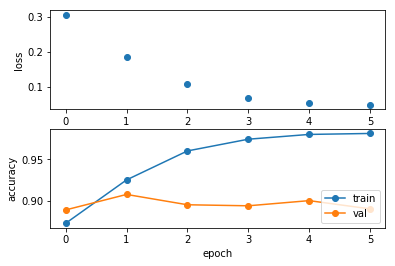

In [10]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

with open(os.path.join('/home/feng/ext2/feng/workspace/residential_building_challenge/20to2_output', 'results.csv'), 'r') as f:
        for line in f:
            numbers = line.split(',')
            if(numbers[0]=='epoch'):
                continue
            try:
                train_loss.append(float(numbers[1]))
                train_acc.append(1-float(numbers[2]))
                valid_loss.append(float(numbers[3]))
                valid_acc.append(1-float(numbers[4]))
            except ValueError:
                continue


# Visualize loss history and training/validation accuracy history
plt.subplot(2, 1, 1)
plt.plot(train_loss, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc, '-o')
plt.plot(valid_acc, '-o')
plt.legend(['train', 'val'], loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Test Model
Make predictions based on test dataset. Visually assess the quality of prediction and compute accuracy based on groundtruth. 

In [11]:
# Check accuracy of model on Test set
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False,
                                              pin_memory=(torch.cuda.is_available()), num_workers=0)
test_epoch(model, test_loader)

Test	Iter: [1/1]	Time 0.547 (0.547)	Loss 1.9000 (1.9000)	Error 0.5000 (0.5000)
[[6 1]
 [7 2]]


(0.5467357635498047, 1.8999793529510498, 0.5)

### Visualize Successful and Failed Examples

In [ ]:
x = np.array([[1,2],[2,3],[3,4]])
mask = [False,False,True]
print(x)

In [ ]:
X_success = np.array([]).reshape((0, 1, 200, 200))
y_success = np.array([]).reshape((0,))
X_failure = np.array([]).reshape((0, 1, 200, 200))
y_failure = np.array([]).reshape((0,))

model.eval() 
for X, y in loader_test:
    X_var = Variable(X.type(dtype), volatile=True)
    scores = model(X_var)
    _, preds = scores.data.cpu().max(1)
    idx_success = (preds == y).numpy() == 1
    idx_failure = (preds != y).numpy() == 1
    X = X.numpy()
    y = y.numpy()
    X_success = np.append(X_success, X[idx_success.tolist(), :, :, :], axis=0)
    y_success = np.append(y_success, y[idx_success.tolist(), ], axis=0)
    X_failure = np.append(X_failure, X[idx_failure.tolist(), :, :, :], axis=0)
    y_failure = np.append(y_failure, preds[idx_failure.tolist(), ], axis=0)
    
y_success = y_success.astype(np.int32)
y_failure = y_failure.astype(np.int32)

In [ ]:
# Sample a batch of successfully classified images
for i in range(12):
    plt.subplot(3, 4, i+1)
    img = np.moveaxis(X_success[i, :, :, :], 0, -1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title(rbc_class_names[y_success[i]])
    plt.show()

In [ ]:
# Sample a batch of incorrectly classified images
plt.title('Failure Examples')
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = np.moveaxis(X_failure[i, :, :, :], 0, -1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title(rbc_class_names[y_failure[i]])
    plt.show()